In [1]:
import matplotlib.pyplot as plt
from sparta_tools import moria, sparta
import plotly.graph_objects as go
import pickle as pkl
import h5py as hp
import os
import copy
import numpy as np
import sys

BASE = '/Users/cosinga/code/'
SIMPATH = '/Users/cosinga/sims/sparta_output/'

sys.path.append(BASE + 'tree_tracks')
from tree_tracks.tracker import Trajectory
from tree_tracks.visual import Image, Movie
from tree_tracks.storage import Tree, Vines, Simulation

In [2]:
massdefs = ['M200m_all_spa', 'Morb-all_all_spa', 'Morb-all_orb_spa', 'Mvir_all_spa', 'Mpeak']
pids = ['parent_id_cat', 'parent_id_orbinf']
others = ['mask_alive', 'mask_cut', 'id', 'x', 'R200m_all_spa', 'phantom']
SIMNAME = 'L0063_N0256_CBol'
SPARTA_FILE = 'sparta_no_cuts.hdf5'
MORIA_FILE = 'moria_tree_cbol_l0063_n0256_no_cuts.hdf5'
mdata = moria.load(SIMPATH + '%s/%s'%(SIMNAME, MORIA_FILE), massdefs + pids + others)
mconfig = moria.loadConfig(SIMPATH + '%s/%s'%(SIMNAME, MORIA_FILE))

simdata = mconfig['simulation']
sim = Simulation(simdata['box_size'], simdata['snap_t'], ['snap_t', 'snap_z'], simdata)
tree = Tree(mdata, sim)

In [3]:

host_id = 9414
host_idx = tree.getIdx(host_id)
print(host_idx)
track_list = tree.traverseTree(host_idx)

# track_list = Tree.unwrapPositions(track_list, sim.getBox())
img = Image(track_list)
img.includeData(['index', 'phantom'])
fig = img.getFig()
img.setName(fig, 'index')
phantom_cidx = img.getDataIdx('phantom')
hover_info = {
    'phantom': '%{customdata[' + str(phantom_cidx) + ']}'
}
img.setHover(fig, hover_info)
fig.show()


8097


In [4]:
SNAPS = [i for i in range(sim.getSnaps())]
mov = Movie(track_list, frame_duration=120, trans_duration=20)
frames = mov.createFrames(SNAPS)
fig = mov.createMovie(frames)
fig.show()


# Making plots of population of escaped subhalos

In [3]:
f = open("esc_masks3.00.pkl", 'rb')
esclist = pkl.load(f)
esc_sub_mask = esclist[0]
host_esc_sub_mask = esclist[1]
f.close()
del esclist
print(esc_sub_mask.sum(), host_esc_sub_mask.sum())

1311 1034


30534


Text(0.5, 1.0, 'Escaping Subhalos (r > 3R)\nEsc Subs / All Halos: 0.034\nphantoms / All Halos: 0.786\nesc phantoms / all phantoms: 0.036\nesc phantoms / esc subs:0.849')

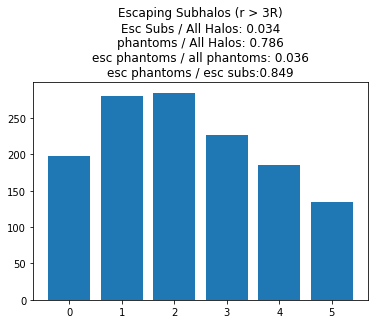

In [22]:
# how many of the escaped subhalos are phantoms?
max_ph = np.max(mdata['phantom'][:, esc_sub_mask], axis = 0)
hist, edges = np.histogram(max_ph, bins = (-0.5, 0.5, 1.5, 2.5, 3.5, 4.5, 5.5))
plt.bar(np.arange(6), hist)
nphantom  = np.any(mdata['phantom'] > 0, axis = 0).sum()
print(nphantom)
esc_frac = esc_sub_mask.sum() / mdata['phantom'].shape[1]
phan_esc_frac = (1 - hist[0]/esc_sub_mask.sum())
phan_frac = nphantom / mdata['phantom'].shape[1]
esc_phan_frac = (hist.sum() - hist[0]) / nphantom
title = "Escaping Subhalos (r > 3R)\nEsc Subs / All Halos: %.3f\nphantoms / All Halos: %.3f\nesc phantoms / all phantoms: %.3f\nesc phantoms / esc subs:%.3f"
plt.title(title%(esc_frac, phan_frac, esc_phan_frac, phan_esc_frac))

In [23]:
sdata = sparta.load(SIMPATH + '%s/%s'%(SIMNAME, SPARTA_FILE), load_halo_data = True, 
                    anl_match = ['hps', 'rsp'], anl_pad_unmatched = True,
                    res_match = ['ifl', 'oct', 'tjy'], res_pad_unmatched = True)

sparta.load: Loading file /Users/cosinga/sims/sparta_output/L0063_N0256_CBol/sparta_no_cuts.hdf5.
sparta.load: Loading 38867/38867 halos from SPARTA file (entire array)...
sparta.load: Matching result IDs in tracer sho, halo 3887/38867
sparta.load: Matching result IDs in tracer sho, halo 7773/38867
sparta.load: Matching result IDs in tracer sho, halo 11659/38867
sparta.load: Matching result IDs in tracer sho, halo 15545/38867
sparta.load: Matching result IDs in tracer sho, halo 19431/38867
sparta.load: Matching result IDs in tracer sho, halo 23317/38867
sparta.load: Matching result IDs in tracer sho, halo 27203/38867
sparta.load: Matching result IDs in tracer sho, halo 31089/38867
sparta.load: Matching result IDs in tracer sho, halo 34975/38867
sparta.load: Matching result IDs in tracer sho, halo 38861/38867


In [68]:
nhalos = mdata['id'].shape[1]
nsnaps = mdata.shape[0]
peri_snap = np.zeros((nhalos)) - 1
phan_mask = np.zeros((nhalos, nsnaps), dtype = bool)
host_idx_arr = np.zeros((nhalos, nsnaps)) - 1
host_phan_mask = np.zeros((nhalos, nsnaps), dtype = bool)
for i in range(nhalos):
    host_ids = mdata['parent_id_orbinf'][:, i]
    is_sub = host_ids > 1e-6
    # if this halo was a subhalo via pericenter definition
    if np.any(is_sub):
        # save snapshot of first pericenter
        peri_snap[i] = np.argmax(is_sub)
        phan_mask[i, :] = mdata['phantom'][:, i] > 1e-6
        
        host_idxs = np.where(np.isin(mdata['id'], host_ids[is_sub]))
        host_idx_arr[i, host_idxs[0]] = host_idxs[1]
        
        host_phan_mask[i, host_idxs[0]] = mdata['phantom'][host_idxs]

        # if there's more than one host, I think I always take the first one
        
            



In [35]:
dif = np.zeros_like(peri_snap)
for i in range(nhalos):
    if peri_snap[i] < 1e-6:
        dif[i] = np.nan
    elif not np.any(phan_snap[i, :]):
        dif[i] = -1
    else:
        phan_idxs = np.where(phan_snap[i,:])[0]
        dif[i] = np.min(abs(phan_idxs - peri_snap[i]))


Text(0.5, 1.0, 'Fraction of Subhalos (orbinf) that are phantoms near their pericenter\nN (<= 2 Snaps) / N subs = 0.315')

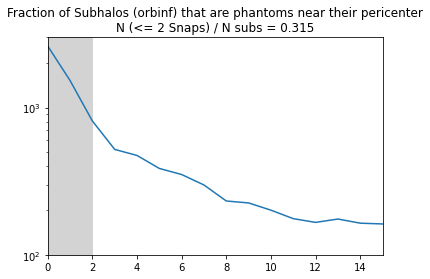

In [46]:
bins = np.arange(-0.5, 193.5, 1)
hist, edges = np.histogram(dif, bins)
nsubs = (peri_snap > 1e-6).sum()
plt.plot(np.arange(193), hist)
plt.xlim(0, 15)
plt.yscale('log')
plt.ylim(1e2, 3e3)
plt.fill_betweenx(plt.ylim(), 0, 2, color = 'lightgray')
title = 'Fraction of Subhalos (orbinf) that are phantoms near their pericenter\n'
plt.title(title + "N (<= 2 Snaps) / N subs = %.3f"%(hist[:3].sum()/nsubs))

In [57]:
# of the subhalos that are phantoms near their pericenter, what do their trajectories look like?
near_idxs = np.where(dif <= 2)[0]
rads = np.zeros((len(near_idxs), mdata.shape[0])) - 1
rad_flags = np.zeros_like(len(near_idxs))
tids = sdata['tcr_sho']['res_tjy']['tracer_id']
for i, idx in enumerate(near_idxs):
# for idx in [near_idxs[0]]:
    sub_ids = mdata['id'][:, idx]
    # locate tracer id
    tcr_inmask = np.isin(tids, sub_ids)
    tcr_idx = np.where(tcr_inmask)[0]

    # locate host
    host_ids = mdata['parent_id_orbinf'][:, idx]
    
    if not len(tcr_idx) > 1:
        rads[i, :] = sdata['tcr_sho']['res_tjy']['r'][tcr_idx, :]
    else: # multiple tracers with same id found
        # find the one with snap that matches peri_snap
        ntcrs = len(tcr_idx)
        tcr_test_dif = np.zeros(ntcrs)
        for t in range(ntcrs):
            r = sdata['tcr_sho']['res_tjy']['r'][tcr_idx[t], :]
            tcr_first_snap = np.argmax(r > -1e-6)
            tcr_test_dif[t] = abs(peri_snap[idx] - tcr_first_snap)
        tcr_idx = tcr_idx[np.argmin(tcr_test_dif)]
        rads[i, :] = sdata['tcr_sho']['res_tjy']['r'][tcr_idx, :]
        



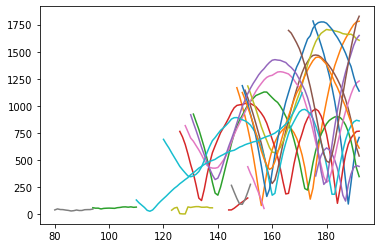

In [58]:
snaps = np.arange(193)
for i in range(20):
    alive = rads[i, :] >= 0
    plt.plot(snaps[alive], rads[i, alive])